In [22]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
import pyspark.sql
import pandas as pd
import os
import getpass
from pyspark.sql import functions as F

In [8]:
# Create output directory
output_dir = "Data_Metrics_Output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

snapshot = "2021-01"
username = getpass.getuser()

### Total number of records (per wiki)

In [ ]:
query = """SELECT wiki AS Wiki, snapshot, COUNT(*) as `Number of Records`
        FROM gmodena.imagerec_prod
        WHERE snapshot='"""+snapshot+"""' 
        GROUP BY wiki, snapshot
        ORDER BY wiki"""
total_number_of_records = spark.sql(query).toPandas()

In [ ]:
total_number_of_records

In [ ]:
total_number_of_records.to_csv(output_dir+"/"+"Total number of records")

### Population statistics

In [ ]:
population_stat = total_number_of_records['Number of Records'].describe()
population_stat.to_csv(output_dir+"/"+"Population statistics")
population_stat

In [ ]:
total_number_of_records.boxplot(column=['Number of Records'])

In [ ]:
pop_stat_median = pd.DataFrame(data={"Median": [total_number_of_records["Number of Records"].median()]})
pop_stat_median.to_csv(output_dir+"/"+"Population statistics median")
pop_stat_median

In [ ]:
pop_stat_mode = total_number_of_records['Number of Records'].mode()
pop_stat_mode.to_csv(output_dir+"/"+"Population statistics mode")
pop_stat_mode

### Total number of images per page

In [ ]:
query = """SELECT wiki AS Wiki, page_id as `Page ID`, COUNT(*) as `Number of Images`
        FROM gmodena.imagerec_prod
        WHERE snapshot='"""+snapshot+"""'
        GROUP BY wiki, page_id
        ORDER BY wiki, page_id"""
total_number_of_images_per_page = spark.sql(query).toPandas()

In [ ]:
total_number_of_images_per_page.to_csv(output_dir+"/"+"Total number of images per page")
total_number_of_images_per_page

#### Breakdown of the number of images being suggested for each page

Keep in mind that pages without an image suggestion will apear as 1.

In [ ]:
query = """SELECT number_of_images AS `Image Suggestions`, count(*) AS `Pages`
        FROM (
        SELECT wiki, page_id, COUNT(*) as number_of_images
        FROM gmodena.imagerec_prod
        WHERE snapshot='"""+snapshot+"""'
        GROUP BY wiki, page_id
        ) AS expr_qry 
        GROUP BY number_of_images
        ORDER BY number_of_images"""
breakdown_of_image_sug_per_page = spark.sql(query).toPandas()

In [ ]:
breakdown_of_image_sug_per_page.set_index('Image Suggestions', inplace=True)
breakdown_of_image_sug_per_page.to_csv(output_dir+"/"+"Breakdown of image sug per page")
breakdown_of_image_sug_per_page

In [ ]:
breakdown_of_image_sug_per_page.plot(y="Pages",
                                     title="Breakdown of Images Suggestion Per Page",
                                     autopct="%.2f",
                                     figsize=(6, 6),
                                     kind="pie");

Breakdown of image suggestion data by confidence rating.
A rating of None indicates that the page has no image suggestion

In [ ]:
query = """SELECT wiki AS Wiki, confidence_rating AS `Confidence Rating`, COUNT(*) AS `Image Suggestions`
        FROM gmodena.imagerec_prod
        WHERE snapshot='"""+snapshot+"""'
        GROUP BY Wiki, `Confidence Rating`
        ORDER BY Wiki, `Confidence Rating`"""
breakdown_of_image_sug_by_confidence_score = spark.sql(query).toPandas()

In [ ]:
breakdown_of_image_sug_by_confidence_score.to_csv(output_dir+"/"+"Breakdown of image sug by conf rating")
breakdown_of_image_sug_by_confidence_score

#### Get articles with more than 3 image suggestions

Assuming no error this table should be empty

In [ ]:
query = """WITH large_image_sug AS 
        (SELECT wiki, page_id, COUNT(*)
        FROM gmodena.imagerec_prod
        WHERE snapshot='"""+snapshot+"""'
        GROUP BY wiki, page_id
        HAVING COUNT(*) > 3)
        SELECT p.* 
        FROM gmodena.imagerec_prod p
        JOIN large_image_sug
        ON large_image_sug.wiki = p.wiki
        AND large_image_sug.page_id = p.page_id
        AND p.snapshot='"""+snapshot+"""'
        ORDER BY p.wiki, p.page_id, p.image_id"""
articles_with_more_image_sug = spark.sql(query).toPandas()

In [ ]:
articles_with_more_image_sug.to_csv(output_dir+"/"+"Articles with more than 3 sug")
articles_with_more_image_sug

### Size and counts of intermediate and final datasets

In [ ]:
query = """SELECT wiki_db AS `Wiki`, snapshot, COUNT(*) AS `Raw Number of Records`
        FROM gmodena.imagerec
        WHERE snapshot='"""+snapshot+"""'
        GROUP BY wiki_db, snapshot
        ORDER BY wiki_db"""
raw_total_number_of_records = spark.sql(query).toPandas()

In [ ]:
raw_total_number_of_records

In [ ]:
total_number_of_records = total_number_of_records.rename(columns={"Number of Records": "Final Number of Records"})
result = pd.merge(raw_total_number_of_records, total_number_of_records, on=["Wiki", "snapshot"])

In [ ]:
result.to_csv(output_dir+"/"+"Counts of intermediate and final datasets")
result

In [ ]:
result.plot(x="Wiki",
            y=["Raw Number of Records", "Final Number of Records"],
            title="Comparison of intermediate and final number of records",
            figsize=(6, 6),
            kind="bar")

### Number of articles with and without valid "instance of"
Todo: Update snapshot and table name to be passed in parameters

In [ ]:
query = """SELECT wiki_db, snapshot,
        COUNT(instance_of) AS with_instance_of,
        SUM(CASE WHEN instance_of IS NULL then 1 ELSE 0 END) AS without_instance_of
        FROM gmodena.imagerec_parquet
        WHERE snapshot = '2021-01'
        GROUP BY wiki_db, snapshot
        ORDER BY wiki_db"""
instance_of_metrics = spark.sql(query).toPandas()

In [ ]:
instance_of_metrics.to_csv(output_dir+"/"+"Number of articles with and without valid instance_of")

In [ ]:
### Number of redirect articles 
Validate that no "page redirects" are present in the dataset.

In [ ]:
query = f"""
        select im.snapshot, count(*) as page_redirect from {username}.imagerec im
        join wmf_raw.mediawiki_page as mp
        where im.wiki_db = mp.wiki_db
        and cast(im.page_id as string) = cast(mp.page_id as string)
        and im.snapshot = mp.snapshot
        and mp.page_is_redirect = 1
        and im.wiki_db != '' and im.snapshot >= "{snapshot}"
        group by im.snapshot"""
page_redirect = spark.sql(query).toPandas()
page_redirect.to_csv(os.path.join(output_dir, "Page redirects"))

### Number of records filtered out

In [ ]:
query = """SELECT wiki, snapshot,
        SUM(CASE WHEN is_article_page = True THEN 1 ELSE 0 END ) as "Final number of records",
        SUM(CASE WHEN is_article_page = False THEN 1 ELSE 0 END ) as "Number of records filtered out"
        FROM {username}.imagerec_prod
        GROUP BY wiki, snapshot"""
filtered_out_records = spark.sql(query).toPandas()
filtered_out_records.to_csv(output_dir+"/"+"Number of records filtered out")

### Distribution of found_on wikis

In [15]:
query = f"""SELECT wiki, page_id, size(found_on) as num_languages
FROM {username}.imagerec_prod
WHERE wiki != ''
AND snapshot = '{snapshot}'
AND source='wikipedia'
GROUP BY wiki, page_id, found_on"""
found_on_all_wikis = spark.sql(query)
# Summarize data to a frequency count of num_languages\n",
found_on_freq = found_on_all_wikis.groupby("num_languages").count().toPandas()
found_on_freq.to_csv(os.path.join(output_dir, "found_on frequencies"))

In [16]:
found_on_all_wikis.select('num_languages').describe().show()

+-------+-----------------+
|summary|    num_languages|
+-------+-----------------+
|  count|          1844700|
|   mean|3.048183444462514|
| stddev|4.660658007696105|
|    min|                1|
|    max|              252|
+-------+-----------------+



In [17]:
found_on_all_wikis.approxQuantile("num_languages", [0.5], 0.25)

[102.0]

#### EDA on found_on

In [19]:
found_on_freq = found_on_all_wikis.groupby("num_languages").count().toPandas()

In [20]:
found_on_freq['count'].plot(kind='bar', figsize=(30, 20), title="Number of languages - frequency distribution")

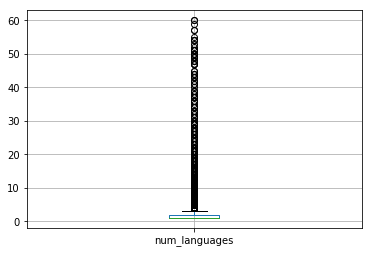

In [26]:
wiki="enwiki"
found_on_metrics = found_on_all_wikis.where(F.col('wiki') == wiki).toPandas()
cond = found_on_metrics["wiki"] == wiki
found_on_metrics[cond].boxplot("num_languages")